In [1]:
#@title Imports for Project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Machine learning libraries and modules
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data visualization library
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/cleaned_data.csv')
df.head()

,id,timestamp,day_of_week,month,day,year,time,datetime,hour,timezone,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,1.543616e+09,Friday,November,30,2018,22:13,2018-11-30 22:13:01,22,America/New_York,...,0.0003,1543593600,28.79,1543579200,42.52,1543600800,26.41,1543575600,40.53,1543611600
1,23f145da-f0c1-4d1f-a184-496bc003a7db,1.544698e+09,Thursday,December,13,2018,10:50,2018-12-13 10:50:11,10,America/New_York,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800
2,357559cb-8c58-4278-a41a-e33b2e0997a3,1.544729e+09,Thursday,December,13,2018,19:15,2018-12-13 19:15:03,19,America/New_York,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800
3,50ef1165-9d23-416c-a65c-18906207b295,1.545005e+09,Sunday,December,16,2018,23:55,2018-12-16 23:55:11,23,America/New_York,...,0.1252,1544979600,39.22,1544954400,43.83,1544990400,33.98,1545019200,38.38,1544986800
4,91c4861c-1780-42b0-bca1-bbd64a422cc3,1.544748e+09,Friday,December,14,2018,00:40,2018-12-14 00:40:07,0,America/New_York,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800


In [4]:
df.shape

(330568, 59)

Upon initial examination, several columns in the dataset exhibit little variability and may not contribute significantly to the analysis. These columns include:

- **year**: All the data in the dataset was collected in 2018. Since there is no variation in the year column, it does not provide any useful information for analysis.

- **month**: The data spans the months of November and December. As a result, the month column will not show significant correlations in this analysis due to the limited range of values.

- **timezone**: The timezone for all records is consistent and set to America/New_York, indicating that the data was collected in Boston. Since there is no variation in timezone, it does not add value to the analysis.

- **cab_type**: The dataset exclusively contains Uber data. Since there is only one cab type present (Uber), the cab type column does not provide any differentiation among records and hence does not contribute to the analysis.

- **surge_multiplier**: For Uber rides, the surge multiplier remains constant at 1. This feature is pertinent to different cab types but remains unvarying for Uber in this dataset. Therefore, it does not provide any discriminatory power for analysis.

- **short-summary**: Both short-summary and long summary are extra text. Icon can describe the same feature in less text. These columns can be revisited if icon has a large impact.

- **long-summary**: Same reasoning as short-summary.

Additionally,

- **product_id**: This column contains cryptic codes that cannot be deciphered without additional context. Given the lack of meaningful interpretation and variability, the product_id column will not be considered for analysis.

By excluding these columns from the analysis, we can focus on features that exhibit variability and are more likely to contribute meaningfully to the predictive models or analytical insights derived from the dataset.

In [5]:
# identify columns with constant values
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
constant_columns

['year', 'timezone', 'cab_type', 'surge_multiplier']

In [6]:
# drop columns with constant values
df = df.loc[:, df.nunique(dropna=False) > 1]
df.shape

(330568, 55)

In [7]:
# drop more unnecessary features 
features_drop = ['product_id', 'month', 'short_summary', 'long_summary', 'latitude', 'longitude']
df = df.drop(features_drop, axis=1)

In [8]:
df.shape

(330568, 49)

### Plotting Feature with Price

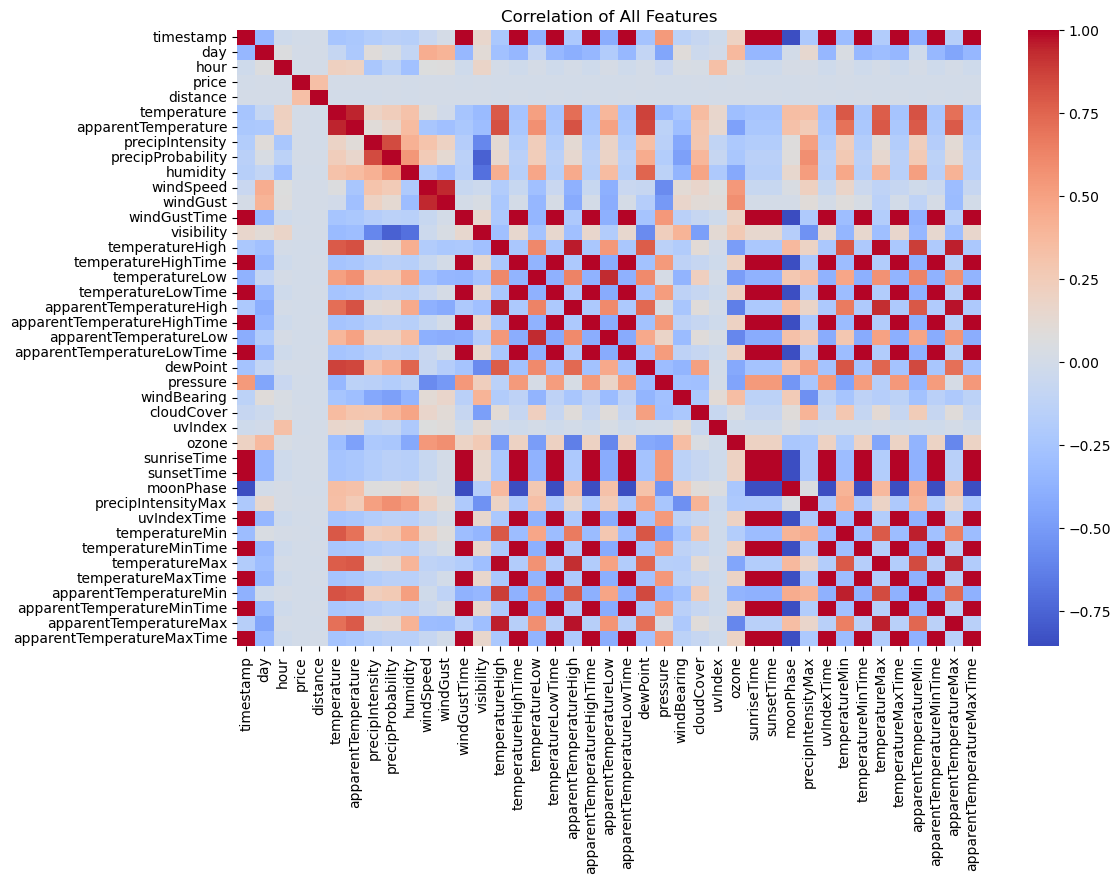

In [9]:
# initially lets start off by determining the correlation of all features
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, fmt=".2f", cmap='coolwarm')
plt.title("Correlation of All Features")
plt.show()

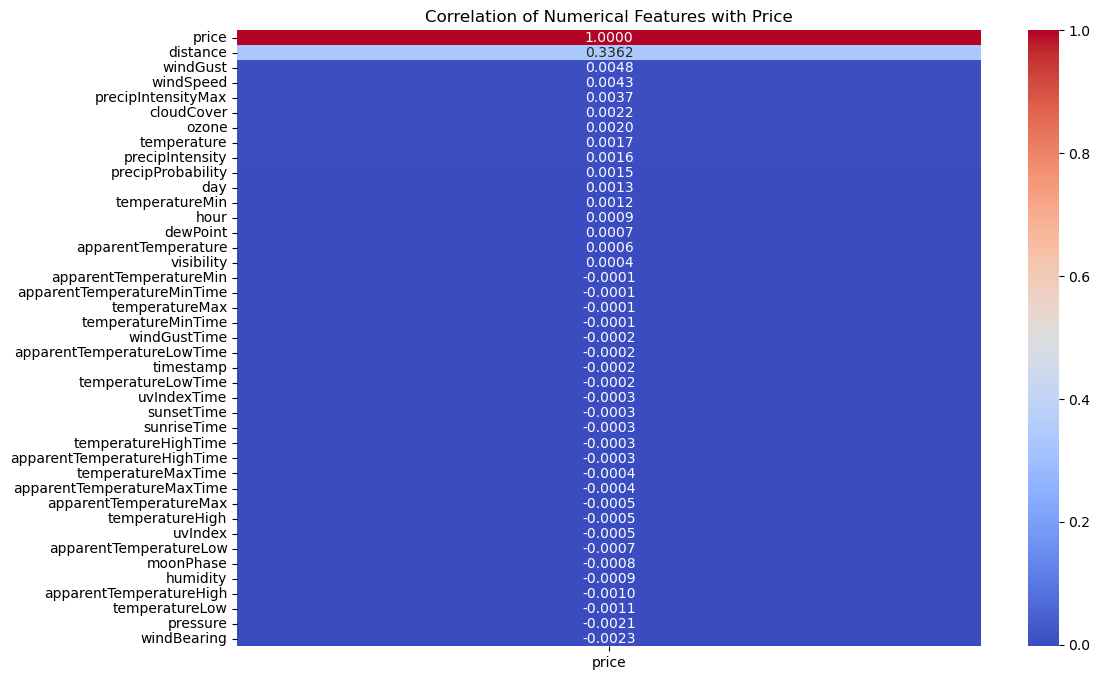

In [10]:
# then lets determine the correlation of price with numerical features
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
corr_with_price = corr_matrix[['price']].sort_values(by='price', ascending=False)
plt.figure(figsize=(12, 8)) 
sns.heatmap(corr_with_price, annot=True, fmt=".4f", cmap='coolwarm', cbar=True)
plt.title("Correlation of Numerical Features with Price")
plt.show()

Also, lets take a look at the relationship between price and categorical features

<Axes: xlabel='price', ylabel='name'>

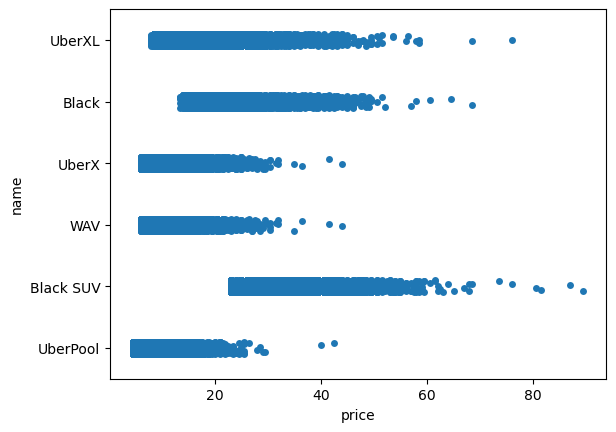

In [11]:
sns.stripplot(data=df, x='price', y='name')

<Axes: xlabel='price', ylabel='icon'>

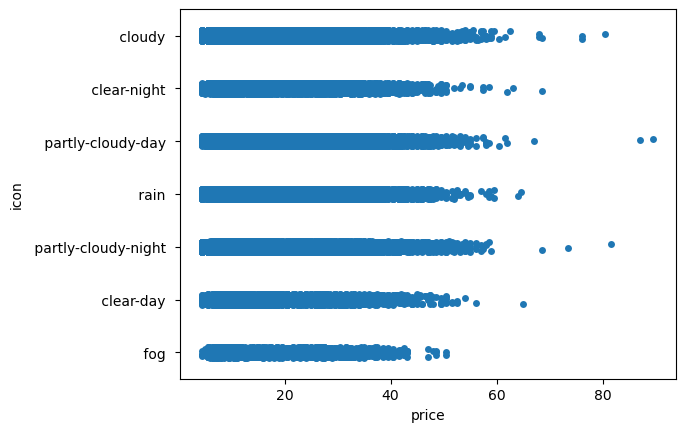

In [12]:
sns.stripplot(data=df, x='price', y='icon')

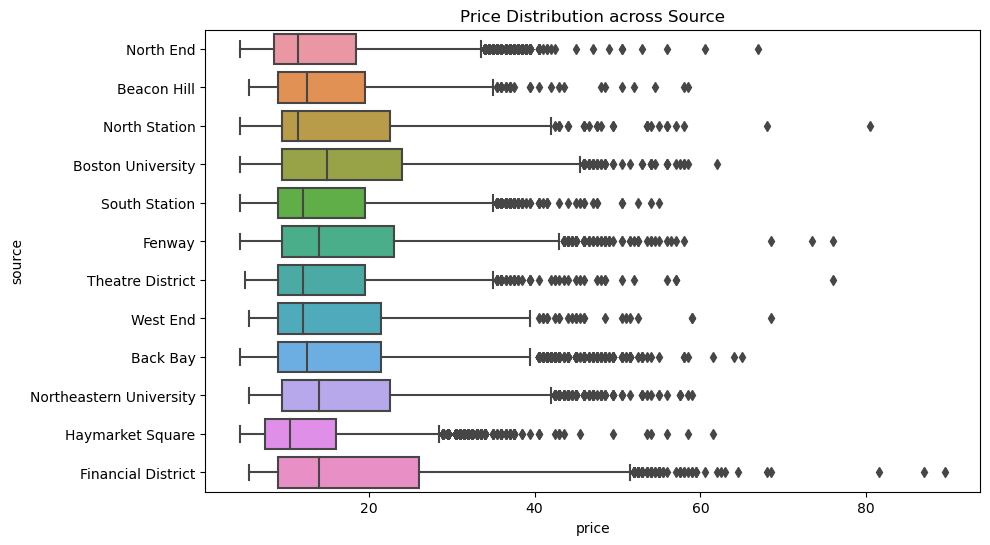

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='price', y='source')
plt.title("Price Distribution across Source")
plt.show()

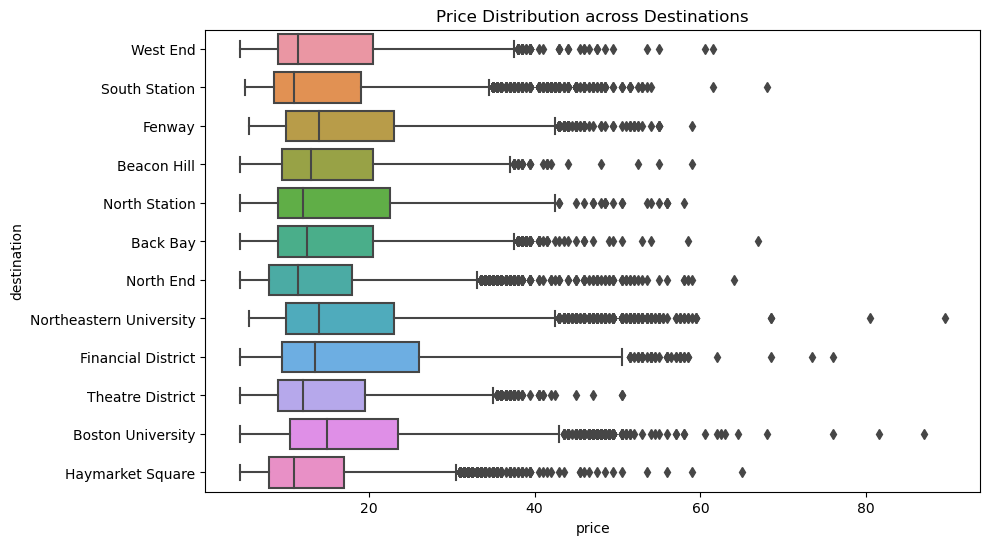

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='price', y='destination')
plt.title("Price Distribution across Destinations")
plt.show()

### Label Encoding

In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df.dtypes

id                              object
timestamp                      float64
day_of_week                     object
day                              int64
time                            object
datetime                        object
hour                             int64
source                          object
destination                     object
name                            object
price                          float64
distance                       float64
temperature                    float64
apparentTemperature            float64
precipIntensity                float64
precipProbability              float64
humidity                       float64
windSpeed                      float64
windGust                       float64
windGustTime                     int64
visibility                     float64
temperatureHigh                float64
temperatureHighTime              int64
temperatureLow                 float64
temperatureLowTime               int64
apparentTemperatureHigh  

In [16]:
columns = ['day_of_week', 'time', 'datetime', 'source',
           'destination','name', 'icon']

columns_to_print = {'name', 'icon'}

for column in columns:
    df[column] = label_encoder.fit_transform(df[column])
    
    if column in columns_to_print:
        print(f"Class mapping of {column}: ")
        for i, item in enumerate(label_encoder.classes_):
            print(f"{item} --> {i}")

Class mapping of name: 
Black --> 0
Black SUV --> 1
UberPool --> 2
UberX --> 3
UberXL --> 4
WAV --> 5
Class mapping of icon: 
 clear-day  --> 0
 clear-night  --> 1
 cloudy  --> 2
 fog  --> 3
 partly-cloudy-day  --> 4
 partly-cloudy-night  --> 5
 rain  --> 6


In [17]:
# shows that object datatypes have been converted
df.head()

,id,timestamp,day_of_week,day,time,datetime,hour,source,destination,name,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,1.543616e+09,0,30,1189,8565,22,6,11,4,...,0.0003,1543593600,28.79,1543579200,42.52,1543600800,26.41,1543575600,40.53,1543611600
1,23f145da-f0c1-4d1f-a184-496bc003a7db,1.544698e+09,4,13,562,17198,10,6,11,0,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800
2,357559cb-8c58-4278-a41a-e33b2e0997a3,1.544729e+09,4,13,1034,18045,19,6,11,3,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800
3,50ef1165-9d23-416c-a65c-18906207b295,1.545005e+09,3,16,1279,25775,23,6,11,5,...,0.1252,1544979600,39.22,1544954400,43.83,1544990400,33.98,1545019200,38.38,1544986800
4,91c4861c-1780-42b0-bca1-bbd64a422cc3,1.544748e+09,0,14,35,18593,0,6,11,1,...,0.0001,1544716800,18.29,1544688000,33.83,1544731200,13.79,1544688000,32.85,1544734800


In [18]:
# check for any null values
df.isnull().sum()

id                             0
timestamp                      0
day_of_week                    0
day                            0
time                           0
datetime                       0
hour                           0
source                         0
destination                    0
name                           0
price                          0
distance                       0
temperature                    0
apparentTemperature            0
precipIntensity                0
precipProbability              0
humidity                       0
windSpeed                      0
windGust                       0
windGustTime                   0
visibility                     0
temperatureHigh                0
temperatureHighTime            0
temperatureLow                 0
temperatureLowTime             0
apparentTemperatureHigh        0
apparentTemperatureHighTime    0
apparentTemperatureLow         0
apparentTemperatureLowTime     0
icon                           0
dewPoint  

### Recursive Feature Elimination (RFE)

In [19]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.feature_selection import RFE

In [20]:
X = df.drop(columns=['price', 'id'])
y = df['price']

#### Accuracy of all features (49)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [22]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(264454, 47) (66114, 47) (264454,) (66114,)


In [23]:
reg = LinearRegression()
reg = reg.fit(X_train, y_train)

predictions = reg.predict(X_test)

print("R^2 score:", metrics.r2_score(y_test, predictions))
print("Mean Squared Error (MSE):", metrics.mean_squared_error(y_test, predictions))
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(y_test, predictions))

R^2 score: 0.4142772089124509
Mean Squared Error (MSE): 42.75833868517134
Mean Absolute Error (MAE): 5.349299585870297


#### Accuracy of 30 features

In [24]:
rfe = RFE(estimator=reg, n_features_to_select=30, verbose=1)
rfe = rfe.fit(X, y)

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.


In [25]:
XX = X[X.columns[rfe.support_]]

In [26]:
XX.columns

Index(['day_of_week', 'day', 'hour', 'source', 'destination', 'name',
       'distance', 'temperature', 'apparentTemperature', 'precipIntensity',
       'precipProbability', 'humidity', 'windSpeed', 'windGust', 'visibility',
       'temperatureHigh', 'temperatureLow', 'apparentTemperatureHigh',
       'apparentTemperatureLow', 'icon', 'dewPoint', 'pressure', 'cloudCover',
       'uvIndex', 'moonPhase', 'precipIntensityMax', 'temperatureMin',
       'temperatureMax', 'apparentTemperatureMin', 'apparentTemperatureMax'],
      dtype='object')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size = 0.20, random_state = 0)

In [28]:
reg1 = LinearRegression()
reg1 = reg1.fit(X_train, y_train)

predictions1 = reg1.predict(X_test)

print("R^2 score:", metrics.r2_score(y_test, predictions1))
print("Mean Squared Error (MSE):", metrics.mean_squared_error(y_test, predictions1))
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(y_test, predictions1))

R^2 score: 0.4143610705774151
Mean Squared Error (MSE): 42.75221670131173
Mean Absolute Error (MAE): 5.348769802334526


### Accuracy of 25 features

In [29]:
rfe = RFE(estimator=reg, n_features_to_select=25, verbose=1)
rfe = rfe.fit(X, y)

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.


In [30]:
XX = X[X.columns[rfe.support_]]

In [31]:
XX.columns
# XX.head()

Index(['day_of_week', 'source', 'name', 'distance', 'temperature',
       'apparentTemperature', 'precipIntensity', 'precipProbability',
       'humidity', 'windSpeed', 'windGust', 'visibility', 'temperatureHigh',
       'temperatureLow', 'apparentTemperatureHigh', 'apparentTemperatureLow',
       'icon', 'dewPoint', 'cloudCover', 'uvIndex', 'moonPhase',
       'precipIntensityMax', 'temperatureMin', 'temperatureMax',
       'apparentTemperatureMax'],
      dtype='object')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size = 0.20, random_state = 0)

In [33]:
reg2 = LinearRegression()
reg2 = reg2.fit(X_train, y_train)

In [34]:
predictions2 = reg2.predict(X_test)

print("R^2 score:", metrics.r2_score(y_test, predictions2))
print("Mean Squared Error (MSE):", metrics.mean_squared_error(y_test, predictions2))
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(y_test, predictions2))

R^2 score: 0.41441432275405554
Mean Squared Error (MSE): 42.74832924014552
Mean Absolute Error (MAE): 5.3484680183096165


### Accuracy of 15 features

In [35]:
rfe = RFE(estimator=reg, n_features_to_select=15, verbose=1)
rfe = rfe.fit(X, y)

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 fe

In [36]:
XX = X[X.columns[rfe.support_]]

In [37]:
XX.columns

Index(['source', 'name', 'distance', 'temperature', 'precipIntensity',
       'precipProbability', 'humidity', 'temperatureHigh',
       'apparentTemperatureHigh', 'dewPoint', 'uvIndex', 'moonPhase',
       'precipIntensityMax', 'temperatureMax', 'apparentTemperatureMax'],
      dtype='object')

In [38]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size = 0.20, random_state = 0)

In [39]:
reg3 = LinearRegression()
reg3 = reg3.fit(X_train, y_train)

In [40]:
predictions3 = reg3.predict(X_test)

print("R^2 score:", metrics.r2_score(y_test, predictions3))
print("Mean Squared Error (MSE):", metrics.mean_squared_error(y_test, predictions3))
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(y_test, predictions3))

R^2 score: 0.4144370176602923
Mean Squared Error (MSE): 42.7466724897133
Mean Absolute Error (MAE): 5.348363257667404


### Accuracy of 2 features

In [41]:
rfe = RFE(estimator=reg, n_features_to_select=2, verbose=1)
rfe = rfe.fit(X, y)

Fitting estimator with 47 features.


Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 fe

In [42]:
XX = X[X.columns[rfe.support_]]

In [43]:
XX.columns

Index(['name', 'distance'], dtype='object')

In [44]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size = 0.20, random_state = 0)

In [45]:
reg4 = LinearRegression()
reg4 = reg4.fit(X_train, y_train)

In [46]:
predictions4 = reg4.predict(X_test)

print("R^2 score:", metrics.r2_score(y_test, predictions4))
print("Mean Squared Error (MSE):", metrics.mean_squared_error(y_test, predictions4))
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(y_test, predictions4))

R^2 score: 0.41451236282866444
Mean Squared Error (MSE): 42.74117221846456
Mean Absolute Error (MAE): 5.347386089812287


### After RFE

In [47]:
XX.columns

Index(['name', 'distance'], dtype='object')

In [48]:
XX.shape

(330568, 2)

In [49]:
XX.head()

,name,distance
0,4,1.11
1,0,1.11
2,3,1.11
3,5,1.11
4,1,1.11


### Test Features

In [50]:
# Machine learning libraries and modules
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data visualization library
import matplotlib.pyplot as plt


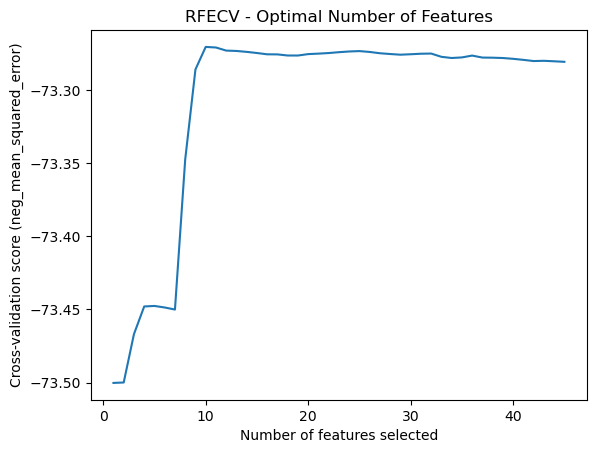

Optimal number of features: 10
Features selected by RFECV: Index(['source', 'destination', 'precipIntensity', 'humidity',
       'temperatureHigh', 'apparentTemperatureHigh', 'uvIndex',
       'precipIntensityMax', 'temperatureMax', 'apparentTemperatureMax'],
      dtype='object')
MSE with RFECV selected features: 72.25468540208657


In [51]:
X = df.drop(columns=['price', 'id', 'name', 'distance'])
y = df['price']

# Splitting dataset into training and testing parts for demonstration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Initialize RFECV
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='neg_mean_squared_error')

# Fit RFECV
rfecv.fit(X_train, y_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (neg_mean_squared_error)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title('RFECV - Optimal Number of Features')
plt.show()

# Optimal number of features
print("Optimal number of features:", rfecv.n_features_)

# Features selected by RFECV
features_selected_rfecv = X_train.columns[rfecv.support_]
print("Features selected by RFECV:", features_selected_rfecv)

# Evaluating performance with the selected features
model.fit(X_train[features_selected_rfecv], y_train)
y_pred = model.predict(X_test[features_selected_rfecv])
mse = mean_squared_error(y_test, y_pred)
print("MSE with RFECV selected features:", mse)


### Drop Features

In [52]:
columns_to_keep = ['price', 'name', 'distance', 'source', 'destination', 'precipIntensity', 'humidity',
                   'temperatureHigh', 'apparentTemperatureHigh', 'uvIndex',
                   'precipIntensityMax', 'temperatureMax', 'apparentTemperatureMax']
df = df[columns_to_keep]

In [53]:
df.shape

(330568, 13)

In [54]:
# Compare 'apparentTemperatureHigh' and 'apparentTemperatureMax'
comparison_result = df['apparentTemperatureHigh'] == df['apparentTemperatureMax']

# You can count the number of True values to see how many rows have matching values
matching_rows_count = comparison_result.sum()

# To see the proportion of matching rows
total_rows = len(df)
proportion_of_matching_rows = matching_rows_count / total_rows

print(f"Number of matching rows: {matching_rows_count}")
print(f"Proportion of matching rows: {proportion_of_matching_rows}")

Number of matching rows: 314174
Proportion of matching rows: 0.9504065729290191


### Final Model

In [55]:
df.head()

,price,name,distance,source,destination,precipIntensity,humidity,temperatureHigh,apparentTemperatureHigh,uvIndex,precipIntensityMax,temperatureMax,apparentTemperatureMax
0,12.0,4,1.11,6,11,0.0000,0.60,42.52,40.53,0,0.0003,42.52,40.53
1,16.0,0,1.11,6,11,0.0000,0.66,33.83,32.85,0,0.0001,33.83,32.85
2,7.5,3,1.11,6,11,0.0000,0.56,33.83,32.85,0,0.0001,33.83,32.85
3,7.5,5,1.11,6,11,0.0567,0.86,43.83,38.38,0,0.1252,43.83,38.38
4,26.0,1,1.11,6,11,0.0000,0.64,33.83,32.85,0,0.0001,33.83,32.85


In [652]:
df.to_csv('./data_feature_engineering.csv', index=False)